# Jazz Solo

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-9.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Train a Long Short-Term Memory network to generate music.

## Download the dataset and required files

In [1]:
%%bash

if [ -e "/tmp/jazz_generator.zip" ]; then
    echo "jazz_generator.zip already exists!"
else
    gdown 1yZ5vKsZiyZZaGfBP-ixfN1PeFljvrt3e -O /tmp/
fi

unzip -qn /tmp/jazz_generator.zip -d /tmp

jazz_generator.zip already exists!


## Import libraries

In [2]:
# !pip install music21==6.7.1 mido pydub
import sys
sys.path.insert(0, '/tmp')
import IPython
from datetime import datetime
import music21
from jazz_generator.data_utils import *
from keras import layers, Input, Model, optimizers, callbacks
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-01-04 13:59:13.469340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736020753.492736  189231 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736020753.501732  189231 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 13:59:13.529902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
music21.__version__

'6.7.1'

## Load the dataset

The preprocessing of the musical data is rendered in terms of [musical values](https://en.wikipedia.org/wiki/Note_value). In music theory, a "value" captures the information needed to play multiple notes at the same time.

In [4]:
# Load the raw music data and preprocess it into "values"
X, Y, n_values, indices_values, chords = load_music_utils('/tmp/jazz_generator/original_metheny.mid')

print('Number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('Total number of unique values:', n_values)
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords:', len(chords))

Number of training examples: 60
Tx (length of sequence): 30
Total number of unique values: 90
Shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords: 19


- **X**: A ($m$, $T_x$, 90) dimensional array.
    - It has $m$ training examples, each of which is a snippet of $T_x$ musical values.
    - At each time step, the input is one of 90 different possible values, represented as a one-hot vector.
        - For example, X[$i$, $t$, :] is a one-hot vector representing the value of the $i-th$ example at time $t$.

- **Y**: A ($Ty$, $m$, 90) dimensional array
    - It is essentially the same as X, but shifted one step to the left (to the past).
    - The data in Y is reordered, where $Ty$ = $Tx$. This format makes it more convenient to feed into the LSTM.
    - The model will use the previous values to predict the next value.
        - So the sequence model will try to predict $y^{<t>}$ given $x^{<1>}$, ..., $x^{<t>}$.

- **n_values**: The number of unique values in this dataset.

- **indices_values**: Python dictionary mapping integers 0 through 89 to musical values.

- **chords**: Chords used in the input midi.

An audio snippet from the training set:

In [ ]:
IPython.display.Audio('/tmp/jazz_generator/30s_seq.mp3')

## Build a Long Short-Term Memory network

Implement the model composed of $T_x$ LSTM cells, where each cell is responsible for learning the following note based on the previous note and context. Each cell has the following schema: 

- [$X_{t}$, $a0_{t-1}$, $c0_{t-1}$] -> RESHAPE() -> LSTM() -> DENSE()

The model will call the LSTM layer $T_x$ times using a for-loop. It is important that all $T_x$ copies have the same weights, the steps should have shared weights that aren't re-initialized. 

In [6]:
# Number of dimensions for the hidden state of each LSTM cell
n_a = 64

# Length of the sequences in the corpus
Tx = X.shape[1]

# Referencing a globally defined shared layer will utilize the same layer-object instance at each time step
reshaper = layers.Reshape((1, n_values))
LSTM_cell = layers.LSTM(n_a, return_state=True)
densor = layers.Dense(n_values, activation='softmax')

# Define inputs, the initial hidden state 'a0' and initial cell state 'c0'
inputs = Input(shape=(Tx, n_values))
a0 = Input(shape=(n_a,))
c0 = Input(shape=(n_a,))
a, c = a0, c0

# Create an empty list to append the outputs while iterate
outputs = []

# Loop over Tx
for t in range(Tx):
    # Select the t-th time step vector from inputs
    x = inputs[:, t, :]
    # Use Reshape() to reshape x to be (1, n_values)
    x = reshaper(x)
    # Perform one step of the LSTM_cell
    a, _, c = LSTM_cell(x, initial_state=[a, c])
    # Apply Dense() to the hidden state output of LSTM_Cell
    output = densor(a)
    # Add the output to "outputs"
    outputs.append(output)
    
# Create model instance
model = Model(inputs=[inputs, a0, c0], outputs=outputs)
model.summary()

I0000 00:00:1736020762.552643  189231 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1689 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 90)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 90)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 90)     │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0], │
│                     │                   │            │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0], │
│                     │                   │            │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0], │
│                     │                   │            │ get_item_9[0][0], │
│                     │                   │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0… │
│                     │                   │            │ get_item_12[0][0… │
│                     │                   │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0… │
│                     │                   │            │ get_item_15[0][0… │
│                     │                   │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0… │
│                     │                   │            │ get_item_18[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0… │
│                     │                   │            │ get_item_21[0][0… │
│                     │                   │            │ get_item_22[0][0… │
│                     │                   │            │ get_item_23[0][0… │
│                     │                   │            │ get_item_24[0][0… │
│                     │                   │            │ get_item_25[0][0… │
│                     │                   │            │ get_item_26[0][0… │
│                     │                   │            │ get_item_27[0][0… │
│                     │                   │            │ get_item_28[0][0… │
│                     │                   │            │ get_item_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 90)        │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     39,680 │ reshape[0][0],    │
│                     │ (None, 64),       │            │ input_layer_1[0]… │
│                     │ (None, 64)]       │            │ input_layer_2[0]… │
│                     │                   │            │ reshape[1][0],  

 Total params: 45,530 (177.85 KB)

 Trainable params: 45,530 (177.85 KB)

 Non-trainable params: 0 (0.00 B)

## Create a custom callback

In [7]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - loss: {logs['loss']:.4f}")

## Compile and train the model

In [8]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy')

epochs = 150
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=int(epochs/10), verbose=1)
a0 = np.zeros((X.shape[0], n_a))
c0 = np.zeros((X.shape[0], n_a))
history = model.fit([X, a0, c0], list(Y), epochs=epochs, verbose=0, callbacks=[custom_verbose, early_stopping])

I0000 00:00:1736020782.459179  189613 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/150
	elapsed time: 18.967s - loss: 129.8282
Epoch 15/150
	elapsed time: 0.198s - loss: 89.2475
Epoch 30/150
	elapsed time: 0.187s - loss: 39.6119
Epoch 45/150
	elapsed time: 0.199s - loss: 13.0531
Epoch 60/150
	elapsed time: 0.190s - loss: 8.8667
Epoch 75/150
	elapsed time: 0.190s - loss: 7.7057
Epoch 90/150
	elapsed time: 0.187s - loss: 7.5464
Epoch 105/150
	elapsed time: 0.191s - loss: 7.4070
Epoch 120/150
	elapsed time: 0.195s - loss: 6.8470
Epoch 135/150
	elapsed time: 0.191s - loss: 6.1826
Epoch 137: early stopping


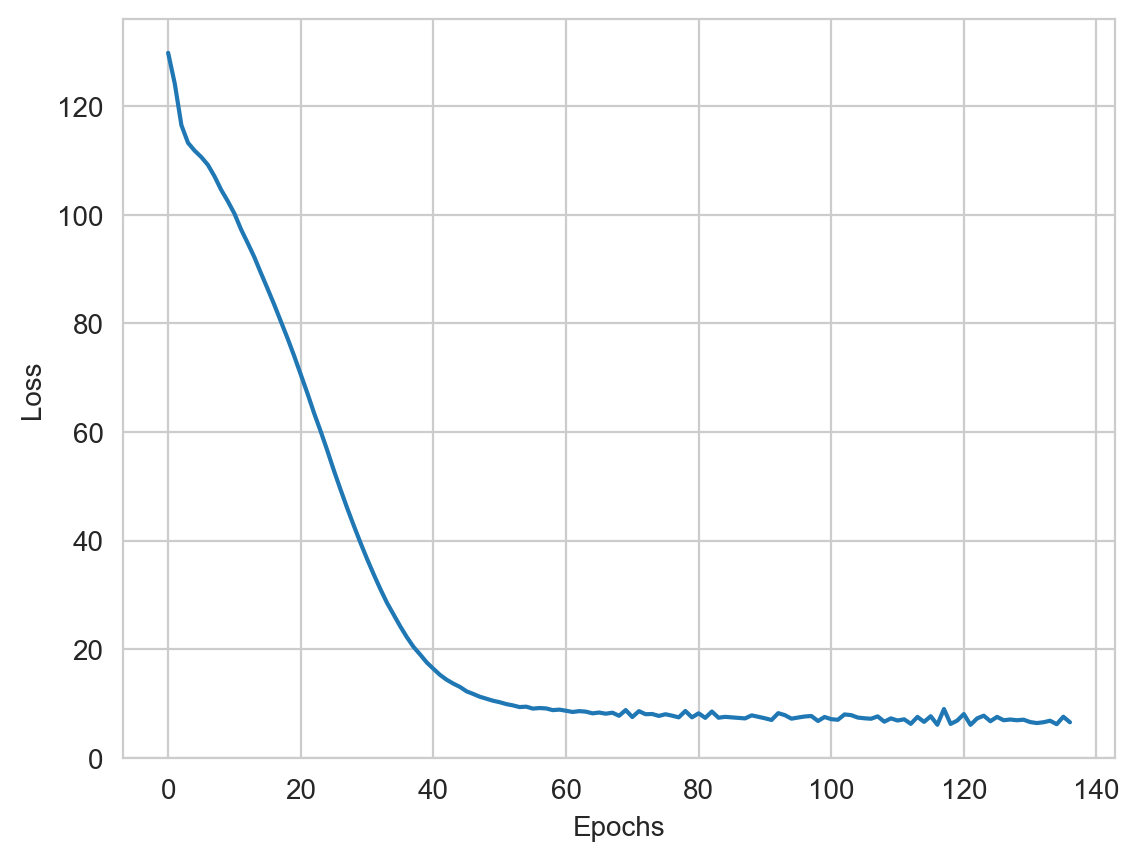

In [9]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluate the model

- Implement a music inference model to sample a sequence of musical values.
- Use the trained "LSTM_cell" and "densor" variables from the previous model to generate a sequence of values.

In [10]:
# Length of the sequences in the corpus
Ty = Tx

# Define the input of the model
x0 = layers.Input(shape=(1, n_values))

# Define initial hidden state and cell state for the decoder LSTM
a0 = layers.Input(shape=(n_a,))
c0 = layers.Input(shape=(n_a,))
x, a, c = x0, a0, c0

# Create an empty list of "outputs" to later store the predicted values
outputs = []

# A KerasTensor cannot be used as input to a TensorFlow function. The function should be wrapped in a layer.
class MyLayer(layers.Layer):
    def call(self, output):
        # Select the next value according to "output" and set "x" to be the one-hot representation of the selected value
        x = tf.math.argmax(output, axis=-1)
        x = tf.one_hot(x, depth=n_values)

        return x

# Loop over Ty and generate a value at every time step
for t in range(Ty):
    # Perform one step of LSTM_cell
    a, _, c = LSTM_cell(x, initial_state=[a, c])
    
    # Apply Dense layer to the hidden state output of the LSTM_cell
    output = densor(a)

    # Append the prediction "output" to "outputs"
    outputs.append(output)

    x = MyLayer()(output)

    # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
    x = layers.RepeatVector(1)(x)
    
# Create model instance with the correct "inputs" and "outputs"
inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)

The inference model generates a sequence of values, then these values are then post-processed into musical chords (meaning that multiple values or notes can be played at the same time).

Most [computational music algorithms](https://en.wikipedia.org/wiki/Computer_music) use some post-processing because it's difficult to generate music that sounds good without it. The post-processing does things like clean up the generated audio by making sure the same sound is not repeated too many times, or that two successive notes are not too far from each other in pitch, and so on.

It could be argued that many of these post-processing steps are hacks, however much of the music generation literature has also focused on hand-crafting post-processors, and a lot of the output quality depends on the quality of the post-processing and not just the quality of the model. Anyway, this post-processing makes a huge difference, so it is also used in this implementation.

In [11]:
_ = generate_music(inference_model, indices_values, chords, output_file='/tmp/jazz_generator/my_music.midi')
mid2wav('/tmp/jazz_generator/my_music.midi', output_file='/tmp/jazz_generator/my_music.wav')
IPython.display.Audio('/tmp/jazz_generator/my_music.wav')

Predicting new values for different set of chords.
Generated 22 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 22 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 22 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 22 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 22 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in/tmp/jazz_generator/my_music.midi
